# 2 - Análise exploratória de dados

Nessa fase, analisaremos a base de treino como um todo, verificando o balanceamento entre as classes e focando, principalmente, na coluna *`tweet_text`*;

In [21]:
# caminho para instalação do pacote mltoolkit, com metricas e gráficos personalizados
# !pip install git+ssh://git@github.com/flimao/mltoolkit

In [22]:
import pandas as pd
import numpy as np
from matplotlib import rcParams, rcParamsDefault, pyplot as plt
import seaborn as sns
from mltoolkit import metrics, plots
from tqdm import tqdm

rcParams.update(rcParamsDefault)
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

tqdm.pandas()

## Importação dos dados

Primeiramente, importamos os dados e aplicamos as transformações utilizadas na fase anterior:

In [23]:
# não tocaremos no conjunto de submissão

tweets_raw = pd.read_csv(
    r'../data/Train3Classes.csv',
)

In [24]:
# trocar tipos para acelerar o processamento (menos espaço em memória)
# e ativar possíveis otimizações internas ao pandas para certos tipos
def mudar_tipos(df):
    df = df.copy()

    df['id'] = df['id'].astype('string')
    df['tweet_date'] = pd.to_datetime(df['tweet_date'])
    df['sentiment'] = df['sentiment'].astype('category')

    return df

def remover_duplicatas(df):
    df = df.copy()

    df = df.drop_duplicates(subset = 'id')

    return df

# o índice é o id, visto que não há repetidos
# vantagem: o índice é removido automaticamente quando separamos em base de treino e teste.
def setar_index(df):
    df = df.copy()

    df = df.set_index('id')

    return df

tweets = (tweets_raw
    .pipe(mudar_tipos)
    .pipe(remover_duplicatas)
    .pipe(setar_index)
)

## Exploração

Vamos conhecer a base mais de perto.

### Balanceamento

Vamos checar a quantidade relativa de *tweets* negativos, positivos e neutros:

In [25]:
tweets.sentiment.value_counts()

0    31696
1    31677
2    31614
Name: sentiment, dtype: int64

O conjunto total parece ser quase exatamente balanceado.

### Relação do sentimento com a data do *tweet*

Vamos ver se o tom do *tweet* (negativo, positivo ou neutro) muda ao longo do tempo:

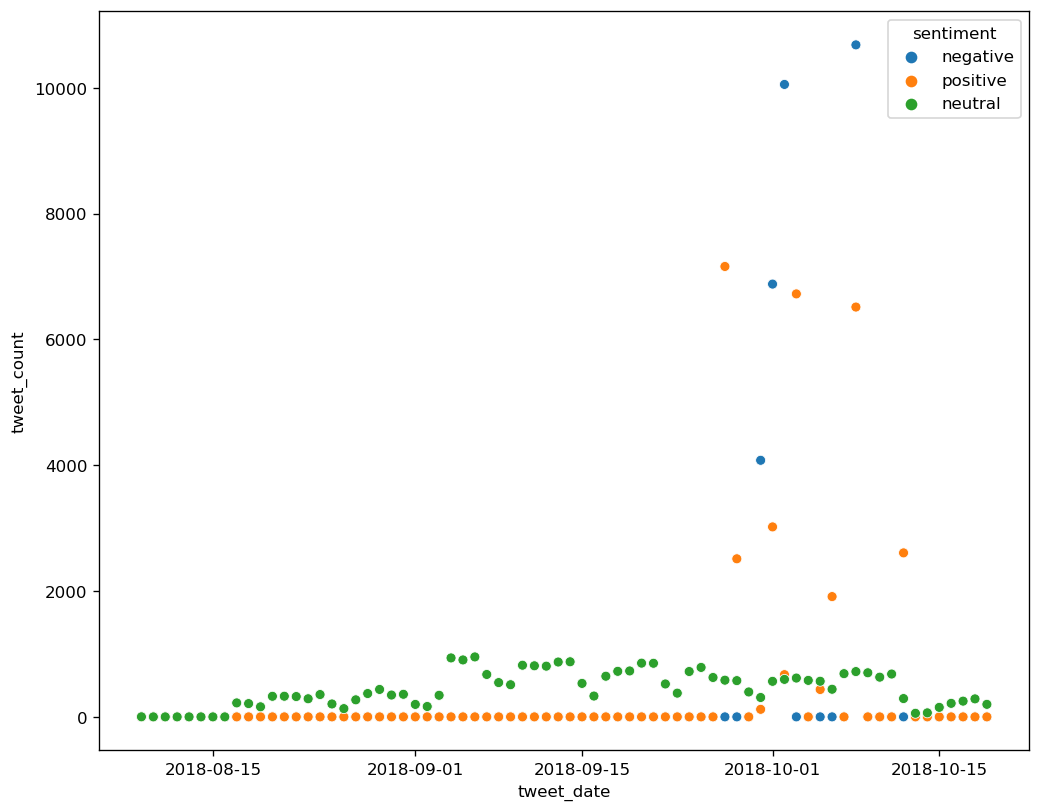

In [26]:
tweets_days = tweets.groupby(by = ['sentiment', pd.Grouper(
    key = 'tweet_date',
    freq = 'D'
)])['tweet_text'].count().reset_index()

tweets_days = tweets_days.rename(columns = {'tweet_text': 'tweet_count'})
#tweets_days.loc[tweets_days.tweet_count == 0, 'tweet_count'] = pd.NA

sns.scatterplot(
    data = tweets_days,
    x = 'tweet_date',
    y = 'tweet_count',
    hue = tweets_days['sentiment'].map({
        0: 'negative',
        1: 'positive',
        2: 'neutral'
    }),
)
plt.show()

In [27]:
# vamos calcular a proporção de tweets de cada sentimento em cada dia

tweets_wide = tweets_days.pivot(
    index = 'tweet_date',
    values = 'tweet_count',
    columns = 'sentiment',
)

tweets_wide_prop = tweets_wide.divide(tweets_wide.sum(axis = 1), axis = 0).dropna()

tweets_wide_prop

tweets_days_prop = tweets_wide_prop.reset_index().melt(
    id_vars = 'tweet_date',
    var_name = 'sentiment',
    value_name = 'tweet_prop',
).set_index(['tweet_date', 'sentiment'])

tweets_days = tweets_days.set_index(['tweet_date', 'sentiment'])

tweets_days_prop

tweets_days['tweet_proportion'] = tweets_days_prop['tweet_prop']
tweets_days = tweets_days.reset_index()

In [28]:
# período em que parece haver grande número de tweets positivos e negativos

tweets_days[
    ('2018-09-26' <= tweets_days.tweet_date) & 
    (tweets_days.tweet_date <= '2018-10-13') &
    (tweets_days.sentiment != 2) & 
    (tweets_days.tweet_count > 0)
]

,tweet_date,sentiment,tweet_count,tweet_proportion
52,2018-09-30 00:00:00+00:00,0,4079,0.905037
53,2018-10-01 00:00:00+00:00,0,6880,0.657430
54,2018-10-02 00:00:00+00:00,0,10054,0.888084
60,2018-10-08 00:00:00+00:00,0,10683,0.596216
121,2018-09-27 00:00:00+00:00,1,7160,0.924706
122,2018-09-28 00:00:00+00:00,1,2513,0.813532
124,2018-09-30 00:00:00+00:00,1,120,0.026625
125,2018-10-01 00:00:00+00:00,1,3020,0.288581
126,2018-10-02 00:00:00+00:00,1,671,0.059270
127,2018-10-03 00:00:00+00:00,1,6724,0.915952


Em conclusão:

* Os *tweets* começam em 9 de agosto, mas só há nessa data um único *tweet*. Os *tweets* começam de fato em número mais expressivo em 17 de agosto.

Além disso, parece haver uma distribuição peculiar dos *tweets* ao longo do tempo:

* *Tweets* de tom neutro parecem se manter constantes (descontando um padrão de sazonalidade) ao longo do tempo;

* *Tweets* negativos e positivos se concentram em um período de duas semanas, entre o fim de setembro e meados de outubro, em grande quantidade.
    
    * *Tweets* de tom negativo só aparecem em 4 dias no período estudado. Nos dias em que aparecem, a proporção de *tweets* negativos (em relação ao total) é de pelo menos 60%;

    * Fora desse período, a maioria esmagadora dos *tweets* são de tom neutro;

    * Esse período de duas semanas é marcado por uma quantidade maior de *tweets* (os de tom neutro se mantém +- constantes, os de tom positivo e negativo aumentam muito).


In [29]:
# exemplos de tweets com sentimento negativo

with pd.option_context('display.max_colwidth', 500):
    display(tweets[tweets.sentiment == 0].sample(10)['tweet_text'])

id
1049280410864308224                                                                                                                                                                                                                       @doransring Quer conversar nenem? :(
1047010906142662656                                                                                                                                                                                                                          @imgzng peguei ranço de naruto :(
1046753815943434241                                                                                                                                                                                                                          @killuardlol Tadinha da soraka :(
1046968164221890560                                                                                                                                                                     

Um evento de grande monta que ocorreu no período de aparente maior polarização (maior proporção de *tweets* com sentimento negativo ou positivo, menos *tweets* de tom neutro) foi o 1° turno da eleição para presidente no Brasil. É razoável que a polarização no sentimento da base de *tweets* seja em parte reflexo da alta polarização da campanha eleitoral.

Ressaltamos que, se for esse o caso, o eventual modelo construído será severamente enviesado. As palavras que ele associará a *tweets* negativos, positivos ou neutros serão tomadas por expressões relativas às eleições, por exemplo, `lula`, `haddad`, `pt`, `bolsonaro` etc. Isso prejudicará a generalização do modelo, pois fora do contexto eleitoral não há motivo para crer que essas palavras são inerentemente positivas, negativas ou neutras.

### Análise do texto
Vamos concentrar nossa atenção agora para o texto em si. Para tal, precisamos fazer um pré-processamento do texto, de forma a facilitar a análise posterior.

In [30]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import re
from unidecode import unidecode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bdzp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bdzp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\bdzp\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Para uma base em português, um pacote de análise NLP muito bom é o `spacy`:

In [31]:
import spacy
nlp = spacy.load("pt_core_news_lg")

Vamos usar um conjunto de *stopwords* customizado disponível em https://gist.github.com/alopes/5358189:

Como estamos fazendo uma análise de sentimentos, não vamos remover a palavra `não`, que está incluída na lista de *stopwords* acima.

In [32]:
with open(r'../data/stopwords_alopes.txt', encoding = 'utf8') as stopword_list:
    lst = stopword_list.read().splitlines()

stopword_list_alopes = set([ stopword.strip() for stopword in lst ])

# em uma análise de sentimento, não queremos remover palavras com conotação negativa
remover_stopwords = {
    'não', 
}

stopword_list_alopes -= remover_stopwords

In [33]:
'não' in stopword_list_alopes

False

Vamos agora definir algumas funções para o pré-processamento do texto.

Em seguida aplicaremos uma função que aplica um conjunto de funções de pré-processamento em ordem.

In [34]:
# Pipeline - Text Preprocessing

def remover_links(string):
    s = re.sub(r'http\S+', '', string, flags=re.MULTILINE)
    return s

def remover_hashtags(string):
    s = re.sub(r'#(\w+)', '', string, flags=re.MULTILINE)
    return s

def remover_mentions(string):
    s = re.sub(r'@(\w+)', '', string, flags=re.MULTILINE)
    return s

def remover_numeros(string):
    s = re.sub(r'\d', '', string)

    return s

def remover_pontuacao(string):
    s = re.sub(r'\W', ' ', string)
    return s

def remover_caracteres_especiais(string):
    s = unidecode(string)
    return s

def caixa_baixa(string):
    s = string.lower()
    return s

def tokenizar(string, tokenizer):
    tokens = tokenizer(string)

    return tokens

def remover_stopwords(word_list, stopword_list):
    filtered_words = []
    for w in word_list:
        if w not in stopword_list:
            filtered_words.append(w)
    
    return filtered_words

# obter radicais via stemmer ou lemmatizer
def obter_radicais(word_list, radicalizer):
    radicalized_words = []
    for w in word_list:
        r_words = radicalizer(w)
        radicalized_words.append(r_words)
    
    return radicalized_words

# para o spacy, as funções são aplicadas em uma ordem e de forma diferentes.
# criamos uma função específica para análise com spacy
def tokenizar_remover_stopwords_obter_radicais_spacy(word_list, nlp, stopword_list = None, retornar_string = True):
    
    if stopword_list is not None:
        for stopword in stopword_list:
            nlp.vocab[stopword].is_stop = True
    
    if isinstance(word_list, str):
        tokens = nlp(word_list)
    else:
        tokens = nlp(' '.join(word_list))
    
    radicalized_words = [ 
        token.lemma_ 
        for token in tokens 
        if not token.is_stop and token.lemma_.strip() != '' and re.sub(r'\W', '', token.lemma_) != ''
    ]
    if retornar_string:
        return ' '.join(radicalized_words)
    
    else:
        return radicalized_words


# aplicação do pipe
def preprocessing(string, preproc_funs_args):
    
    input_arg = string
    output = None

    for preproc_fun_args in preproc_funs_args:
        if isinstance(preproc_fun_args, tuple):
            preproc_fun, kwargs = preproc_fun_args
        else:
            preproc_fun = preproc_fun_args
            kwargs = dict()

        output = preproc_fun(input_arg, **kwargs)
        input_arg = output
    
    return output

In [35]:
# a função preprocessing_full aplica todas as transformações possíveis

preprocessing_full = lambda s: preprocessing(s, preproc_funs_args = [
        remover_links,
        remover_hashtags,
        remover_mentions,
        remover_numeros,
        remover_caracteres_especiais,
        caixa_baixa,
        #remover_pontuacao,
        #(remover_stopwords, dict(stopword_list = stopword_list_alopes)),
        (tokenizar_remover_stopwords_obter_radicais_spacy, dict(
            nlp = nlp,
            stopword_list = stopword_list_alopes,
        )),
])



Vamos extrair uma amostra da base de *tweets* e aplicar a função de pré-processamento:

In [37]:
amostra_eda = 5000
tweets_sample = tweets.sample(amostra_eda)
radicais = tweets_sample['tweet_text'].progress_apply(preprocessing_full)

100%|██████████| 5000/5000 [01:13<00:00, 68.20it/s]


Agora estamos prontos para fazer uma análise exploratória no texto.

#### Análise de frequência de palavras

Vamos contar as palavras, separando por sentimento:

In [38]:
from collections import Counter

# função para contar as palavras separando por sentimento
def contar_palavras(tweets):

    uniques = []
    for sentiment in tweets['sentiment'].cat.categories:

        frase = ' '.join(tweets.loc[tweets['sentiment'] == sentiment, 'radicais']).strip()
        freqcounter = Counter(frase.split(' '))

        freq_df = pd.DataFrame(pd.Series(freqcounter), columns = ['frequency'])

        freq_df['sentiment'] = sentiment
        uniques.append(freq_df)
    
    return pd.concat(uniques)


In [39]:
tweets_radicais = tweets.copy()
tweets_radicais['radicais'] = radicais
tweets_radicais = tweets_radicais[tweets_radicais.radicais.notna()]
palavras = contar_palavras(tweets_radicais)

In [40]:
# só vamos olhar as palavras mais frequentes

topn = 15
palavras_topn = palavras.sort_values(by = 'frequency', ascending = False).groupby('sentiment').head(topn).reset_index()
palavras_topn = palavras_topn.rename(columns = {'index': 'palavra'})
palavras_topn

,palavra,frequency,sentiment
0,nao,423,0
1,nao,370,1
2,d,198,1
3,pra,176,1
4,pra,163,0
5,ir,161,1
6,nao,161,2
7,to,154,0
8,querer,150,0
9,bolsonaro,137,2


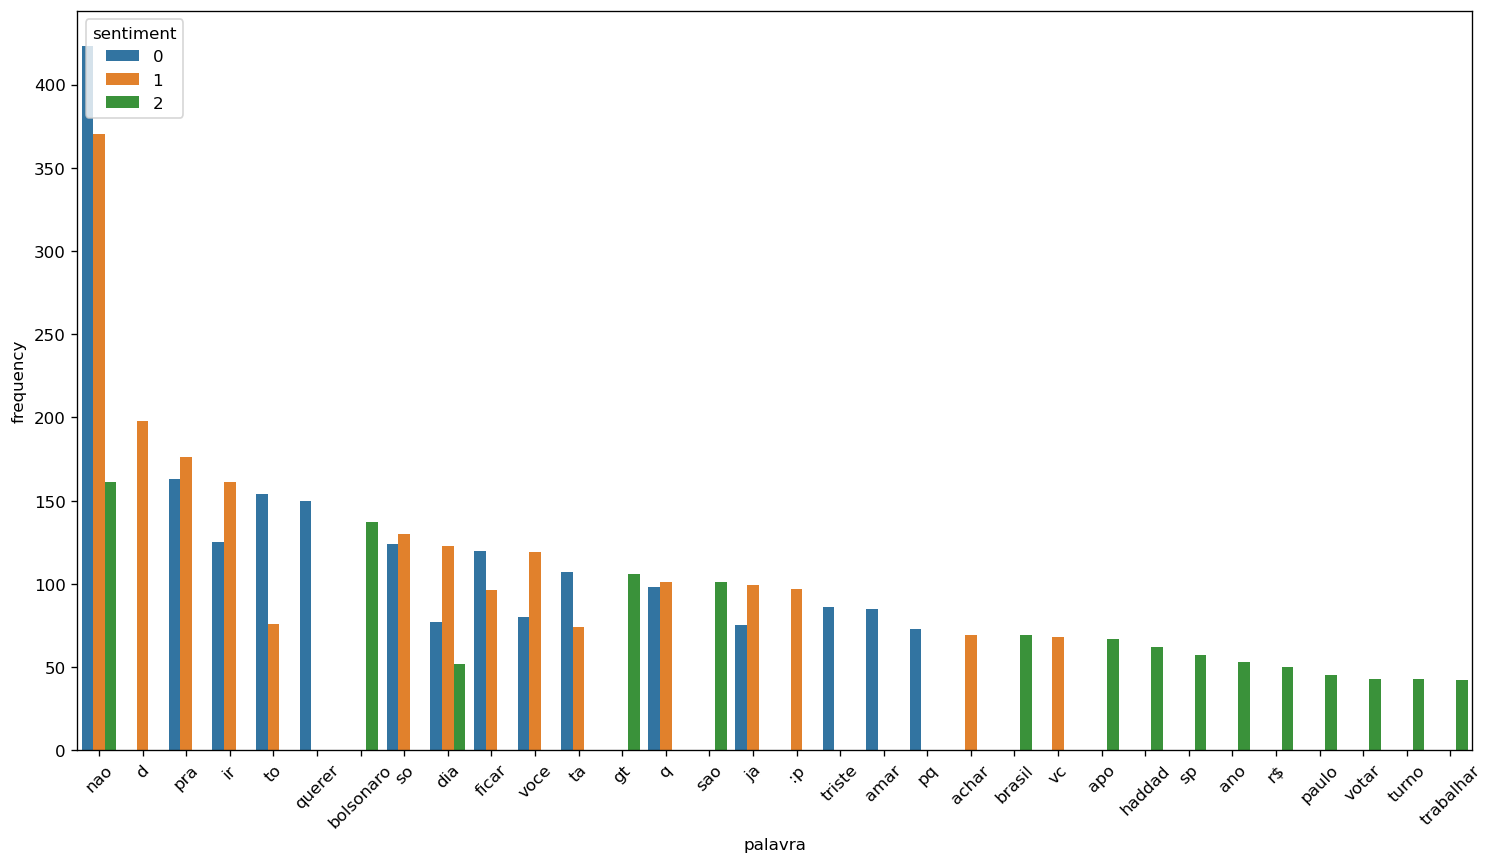

In [41]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.barplot(
    data = palavras_topn,
    x = 'palavra',
    y = 'frequency',
    hue = 'sentiment',
    ax = ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

Algumas conclusões:

* A palavra `não` foi a mais frequente, e parece ter conteúdo sentimental alto; no entanto, há quantidade grande de *tweets* positivos contendo a palavra `não`;
* Palavras relacionadas à eleição (`bolsonaro`, `haddad`, `pt`) são proeminentes na base. No entanto, surpreendentemente, aparentam ter conteúdo neutro.

#### *Word Cloud*

Vamos visualizar as palavras em si, em um *word cloud*:

Word cloud com sentimento negativo:


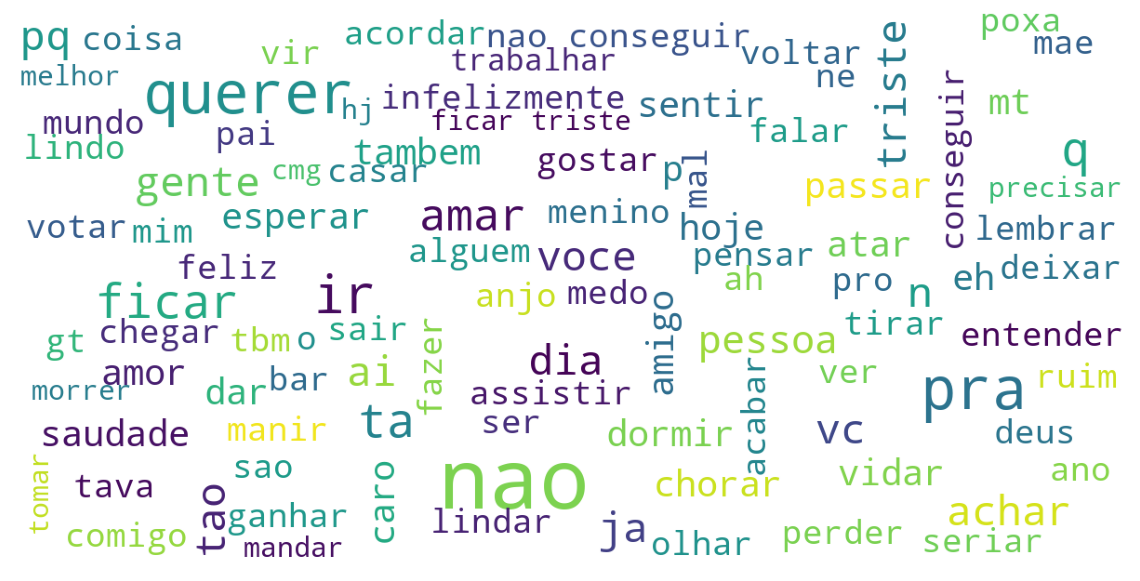

Word cloud com sentimento positivo:


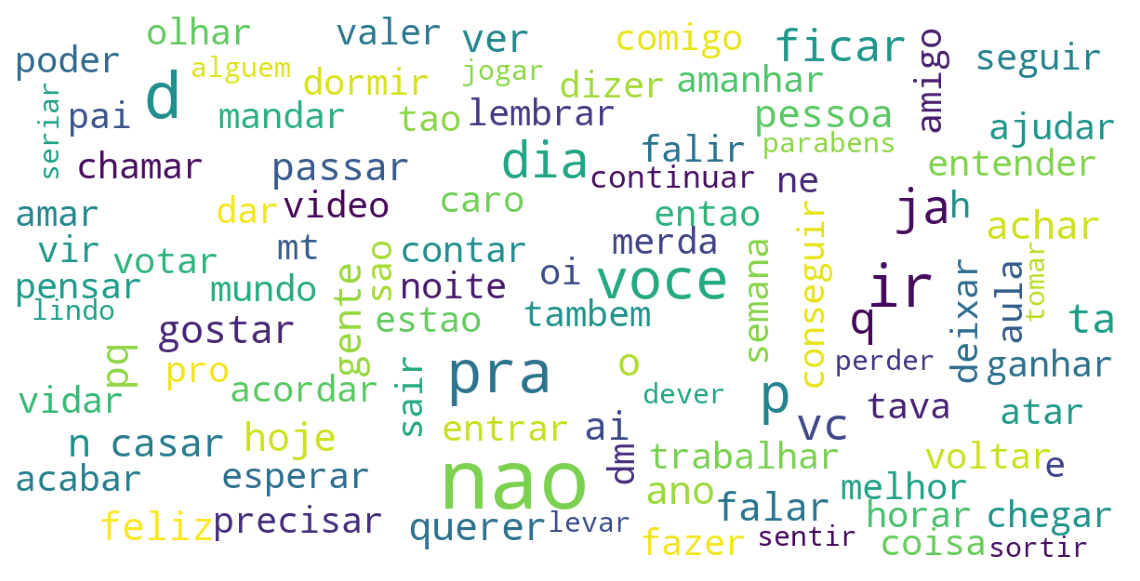

Word cloud com sentimento neutro:


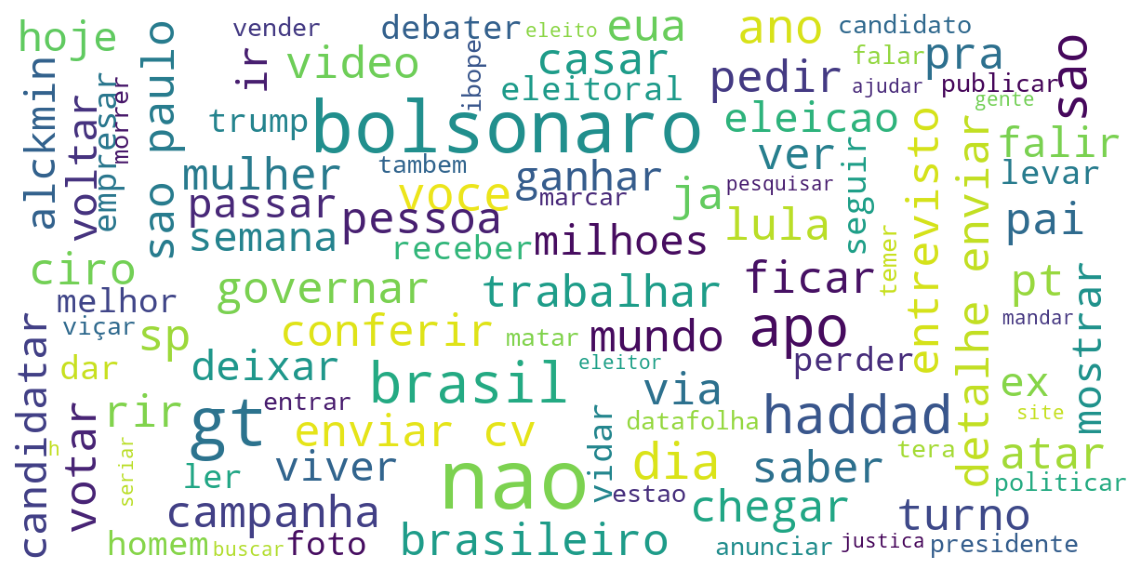

In [42]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

for sentiment, sentiment_desc in zip(tweets_radicais.sentiment.cat.categories, [ 'negativo', 'positivo', 'neutro']):
    print(f'Word cloud com sentimento {sentiment_desc}:')
    total = ' '.join(tweets_radicais.loc[tweets_radicais.sentiment == sentiment, 'radicais'])
    show_wordcloud(total)

#### Análise de tamanho de frase

Vamos visualizar algumas estatísticas da base de *tweets*:

In [43]:
# a função preprocessing_obter_stats será usada para obter algumas estatísticas
preprocessing_obter_stats = lambda s: preprocessing(s, preproc_funs_args = [
        remover_links,
        #remover_hashtags,
        remover_mentions,
        #remover_numeros,
        #remover_caracteres_especiais,
        #caixa_baixa,
        #remover_pontuacao,
        #(remover_stopwords, dict(stopword_list = stopword_list_alopes)),
        #(tokenizar_remover_stopwords_obter_radicais_spacy, dict(
        #    nlp = nlp,
        #    stopword_list = stopword_list_alopes,
        #)),
])

In [55]:
tweets_obter_stats = tweets['tweet_text'].progress_apply(preprocessing_obter_stats)

100%|██████████| 94987/94987 [00:01<00:00, 48506.06it/s]


100%|██████████| 94987/94987 [00:00<00:00, 345226.07it/s]


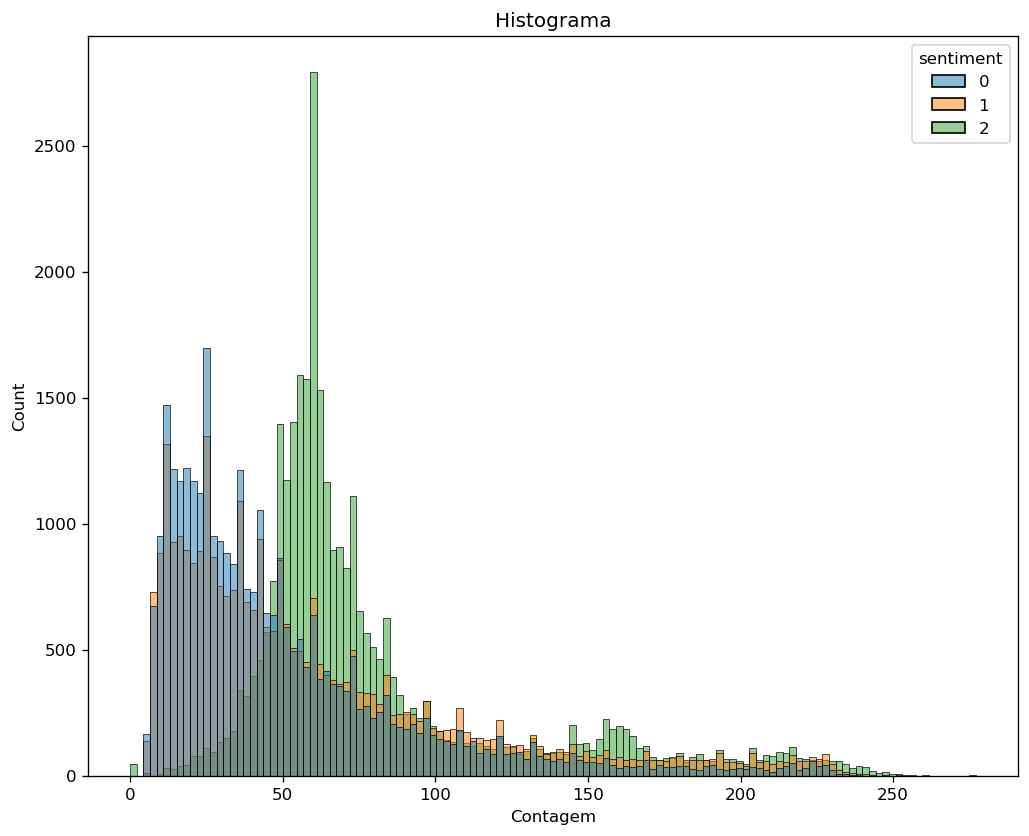

In [56]:
len_frases = tweets_obter_stats.str.replace(' ', '').progress_apply(len)

fig, ax = plt.subplots()
sns.histplot(x = len_frases, hue = tweets.sentiment, ax = ax)
#len_frases.plot.hist(ax = ax, label = 'Número de caracteres da frase')
#ax.axvline(x = len_frases.mean(), label = f'Média = {len_frases.mean():.1f} caracteres', ls = '--', color = 'black')
ax.set_xlabel('Contagem')
ax.set_title('Histograma')
#plt.legend()
plt.show()

100%|██████████| 94987/94987 [00:00<00:00, 278547.37it/s]


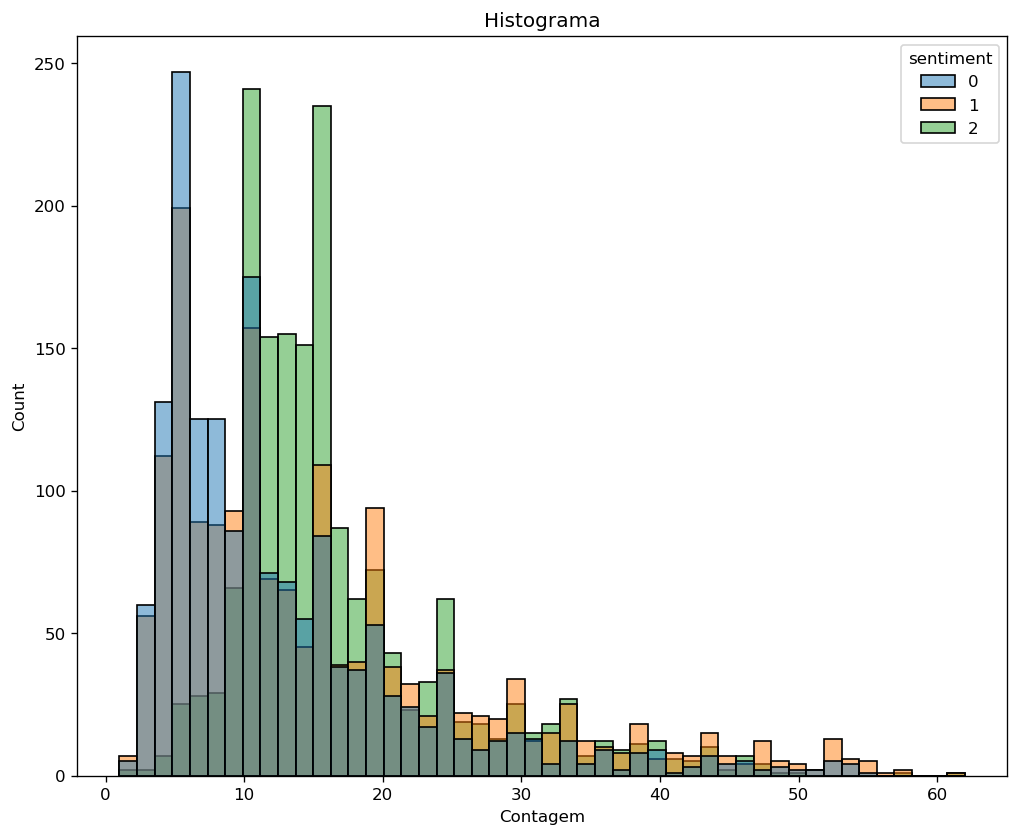

In [48]:
contagem_palavras = tweets_obter_stats.str.split(' ').progress_apply(len)

fig, ax = plt.subplots()
sns.histplot(x = contagem_palavras, hue = tweets_radicais.sentiment, ax = ax)
#contagem_palavras.plot.hist(ax = ax, label = 'Número de palavras')
#ax.axvline(x = contagem_palavras.mean(), label = f'Média = {contagem_palavras.mean():.1f} palavras', ls = '--', color = 'black')
ax.set_xlabel('Contagem')
ax.set_title('Histograma')
#plt.legend()
plt.show()

In [61]:
tweets_stats = pd.DataFrame({
    'n_caract': len_frases,
    'n_palavras': contagem_palavras,
    'sentiment': tweets['sentiment']
})

tweets_stats.groupby('sentiment').agg({
    'n_caract': 'mean',
    'n_palavras': 'mean'
})

,n_caract,n_palavras
sentiment,,
0,50.940024,13.090832
1,61.479622,15.336111
2,81.985987,16.474758


In [60]:
len_frases.mean()

64.78770779159254

In [51]:
contagem_palavras.mean()

14.965858485898071

Em resumo: a média de caracteres na frase é de 64.8 caracteres (o limite de caracteres do *Twitter* é 280 caracteres), com frases curtas dominando. 

A média de palavras em um *tweet* (também excluindo *stopwords*) é de 6.9 palavras, com *tweets* com poucas palavras dominando também.

No entanto, há uma diferença entre *tweets* com tom neutro e *tweets* com tom positivo ou negativo: **os *tweets* com sentimento neutro tem maior número de caracteres e maior número de palavras do que *tweets* com sentimento positivo ou negativo**. 

Além disso, a distribuição das contagens de caracteres e de palavras são mais enviesadas a esquerda. Em outras palavras, quando o *tweet* tem sentimento negativo ou positivo, as frases curtas dominam mais do que quando o *tweet* é de tom neutro.

Logo, um *feature* que é potencialmente útil para distinguir *tweets* neutros de *tweets* positivos ou negativos é seu número de palavras/caracteres.

#### Análise da busca feita

A base registra qual busca foi feita que resultou nos *tweets* específicos que foram incluídos na base. Vamos analisá-los.

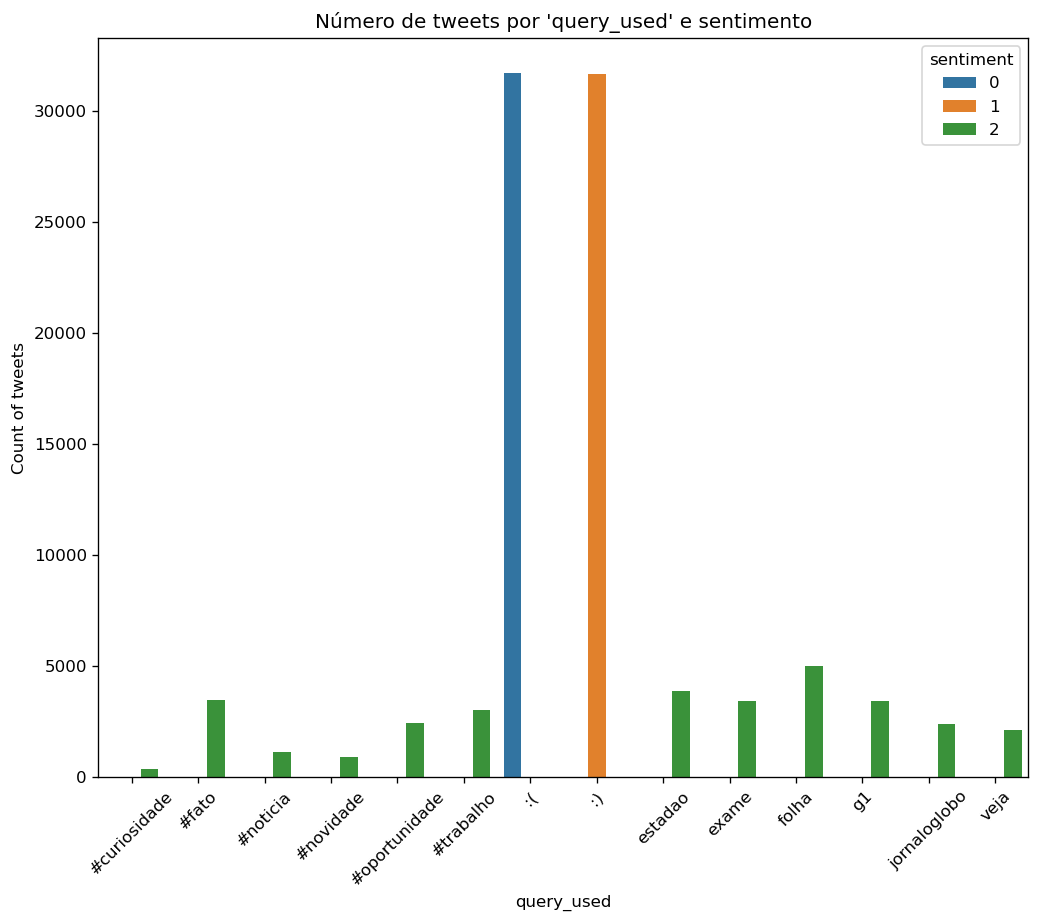

In [45]:
tweets_query = tweets.groupby(['query_used', 'sentiment']).tweet_text.count().reset_index()

ax = sns.barplot(
    data = tweets_query[tweets_query.tweet_text > 0],
    x = 'query_used',
    y = 'tweet_text',
    hue = 'sentiment',
)

ax.set_ylabel('Count of tweets')
ax.set_title("Número de tweets por 'query_used' e sentimento")
plt.xticks(rotation = 45)
plt.show()

Parece que, fora as *queries* `:)` e `:(`, todas as outras resultaram em *tweets* exclusivamente com tom neutro. A *query* `:)` resultou em *tweets* classificados com tom exclusivamente positivo, e a *query* `:(` resultou em *tweets* com tom exclusivamente negativo.

Logo, na base de treino, conseguimos prever o tom do *tweet* exclusivamente pela *query* utilizada para produzí-lo. No entanto, é improvável que isso se reproduza no universo de *tweets* em geral: um *tweet* negativo ou positivo pode ser retornado mesmo com a busca sendo relacionadas a notícias, por exemplo. Em outras palavras, corremos o risco de a base de treino não ser representativa do universo de *tweets* em geral. Por esse motivo, **usaremos uma mistura dos radicais com a busca utilizada para treinar o modelo final.**